In [1]:
import pandas as pd
import numpy as np

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import neologdn
import MeCab

import re

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# # プログレスバーのラベル設定
tqdm_notebook.pandas(desc="progress: ")

In [2]:
df = pd.read_pickle('all_text_id_wakatigaki_181201.pkl')
df.head()

,surface,yomi,original,type,katsuyoukei,katsuyougata,内容_id
0,案件,アンケン,案件,名詞-一般,,,0
1,個別,コベツ,個別,名詞-形容動詞語幹,,,0
2,の,ノ,の,助詞-連体化,,,0
3,技術,ギジュツ,技術,名詞-一般,,,0
4,相談,ソウダン,相談,名詞-サ変接続,,,0


## TF値算出

In [3]:
# 単語名は同一でも品詞名が違う組み合わせがあるので単語名と品詞名を組み合わせた要素を格納した新規カラムを作成する
df['original_type'] = df['original'] + '_' + df['type']
df.head()

,surface,yomi,original,type,katsuyoukei,katsuyougata,内容_id,original_type
0,案件,アンケン,案件,名詞-一般,,,0,案件_名詞-一般
1,個別,コベツ,個別,名詞-形容動詞語幹,,,0,個別_名詞-形容動詞語幹
2,の,ノ,の,助詞-連体化,,,0,の_助詞-連体化
3,技術,ギジュツ,技術,名詞-一般,,,0,技術_名詞-一般
4,相談,ソウダン,相談,名詞-サ変接続,,,0,相談_名詞-サ変接続


In [4]:
# 必要カラムのみ抽出
df = df[['yomi', '内容_id', 'original_type']]
df.head()

,yomi,内容_id,original_type
0,アンケン,0,案件_名詞-一般
1,コベツ,0,個別_名詞-形容動詞語幹
2,ノ,0,の_助詞-連体化
3,ギジュツ,0,技術_名詞-一般
4,ソウダン,0,相談_名詞-サ変接続


In [5]:
# 1つの文書内で出現する単語の出現回数をカウント

# [内容]×[original_type]の組み合わせの数をカウント
contents_word_cnt_df = df.groupby(['内容_id', 'original_type']).count().reset_index()
contents_word_cnt_df = contents_word_cnt_df.rename(columns={'yomi':'count'})
contents_word_cnt_df.head()

,内容_id,original_type,count
0,0,!_記号-一般,1
1,0,て_助詞-接続助詞,1
2,0,の_助詞-連体化,1
3,0,ます_助動詞,2
4,0,乗る_動詞-自立,2


In [6]:
# 文書毎に含まれる単語数をカウント

# [内容_id]カラムをグループ化しカウント　
# reset_index関数を使い[内容]カラムをindex部分からデータ列部分に戻す
per_sentence_word_cnt = df.groupby('内容_id')['original_type'].count().reset_index()
per_sentence_word_cnt = per_sentence_word_cnt.rename(columns={'original_type':'word_count'})
per_sentence_word_cnt.head()

,内容_id,word_count
0,0,11
1,1,12
2,2,13
3,3,13
4,4,5


In [7]:
# [count]と[word_count]を [内容]で紐づけ
contents_merge_df = pd.merge(contents_word_cnt_df, per_sentence_word_cnt, on='内容_id', how='inner')
contents_merge_df.head(27)

,内容_id,original_type,count,word_count
0,0,!_記号-一般,1,11
1,0,て_助詞-接続助詞,1,11
2,0,の_助詞-連体化,1,11
3,0,ます_助動詞,2,11
4,0,乗る_動詞-自立,2,11
5,0,個別_名詞-形容動詞語幹,1,11
6,0,技術_名詞-一般,1,11
7,0,案件_名詞-一般,1,11
8,0,相談_名詞-サ変接続,1,11
9,1,。_記号-句点,1,12


In [8]:
# 内容_idの数が欠損していないか確認
len(contents_merge_df['内容_id'].value_counts())

50

In [9]:
# 欠損値があるか確認
contents_merge_df.isnull().any()

内容_id            False
original_type    False
count            False
word_count       False
dtype: bool

In [10]:
# tf値算出に必要なカラム（分子と分母の値があるカラム）のみ抽出
tmp_tf_df = contents_merge_df[['count', 'word_count']]
tmp_tf_df.head()

,count,word_count
0,1,11
1,1,11
2,1,11
3,2,11
4,2,11


In [11]:
# tf値算出
# axis=1をつけないと"occurred at index count"とエラーが発生する（デフォルトがaxis=0のため）
contents_merge_df['tf'] = tmp_tf_df.progress_apply(lambda x: x['count'] / x['word_count'], axis=1)

In [12]:
# tf値が紐づいたか確認
contents_merge_df.head()

,内容_id,original_type,count,word_count,tf
0,0,!_記号-一般,1,11,0.090909
1,0,て_助詞-接続助詞,1,11,0.090909
2,0,の_助詞-連体化,1,11,0.090909
3,0,ます_助動詞,2,11,0.181818
4,0,乗る_動詞-自立,2,11,0.181818


## IDF値算出

In [13]:
# idfの分子（全文書数）
len(contents_word_cnt_df['内容_id'].value_counts())

50

In [14]:
# idfの分母「各単語が出現する文書の数」の算出
# [original_type]×[内容_id]のクロス集計表を作成

idf_pivot_df = pd.pivot_table(contents_merge_df, index='original_type', columns='内容_id', aggfunc=len, values='count')
#tf_pivot_df = pd.pivot_table(contents_merge_df, index='original_type', columns='内容', values='count')#aggfuncを指定しないと[count]カラムの数字が入る
idf_pivot_df.head()

内容_id,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
original_type,,,,,,,,,,,,,,,,,,,,,
!_記号-一般,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
..._記号-一般,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10歳_名詞-固有名詞-一般,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2週_名詞-固有名詞-一般,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
?_記号-一般,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
idf_pivot_df1 = idf_pivot_df > 0
idf_pivot_df1# 1以上ならTrue、1未満ならFalse

内容_id,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
original_type,,,,,,,,,,,,,,,,,,,,,
!_記号-一般,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
..._記号-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10歳_名詞-固有名詞-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2週_名詞-固有名詞-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
?_記号-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BOOKMARK_名詞-固有名詞-人名-一般,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
PC_名詞-固有名詞-一般,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
、_記号-読点,False,False,True,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
。_記号-句点,False,True,False,False,False,True,True,False,False,True,...,True,True,True,False,True,True,False,True,True,False


In [16]:
# True＝１なのでTureの数を行毎に合計
# それを格納するカラム[word_include_text_count]を追加
# この値がidfの分母となる
idf_pivot_df1['word_include_text_count'] = idf_pivot_df1.sum(axis=1)
idf_pivot_df1

内容_id,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,word_include_text_count
original_type,,,,,,,,,,,,,,,,,,,,,
!_記号-一般,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
..._記号-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6
10歳_名詞-固有名詞-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2週_名詞-固有名詞-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
?_記号-一般,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
BOOKMARK_名詞-固有名詞-人名-一般,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
PC_名詞-固有名詞-一般,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
、_記号-読点,False,False,True,False,False,True,False,False,False,False,...,False,True,False,True,False,False,False,False,False,14
。_記号-句点,False,True,False,False,False,True,True,False,False,True,...,True,True,False,True,True,False,True,True,False,21


In [17]:
# 必要なカラム(新規作成カラム、マージするときのキーのカラム）のみ抽出
idf_pivot_df2 = idf_pivot_df1.reset_index()[['original_type', 'word_include_text_count']]
idf_pivot_df2

内容_id,original_type,word_include_text_count
0,!_記号-一般,1
1,..._記号-一般,6
2,10歳_名詞-固有名詞-一般,1
3,2週_名詞-固有名詞-一般,1
4,?_記号-一般,1
5,BOOKMARK_名詞-固有名詞-人名-一般,1
6,PC_名詞-固有名詞-一般,1
7,、_記号-読点,14
8,。_記号-句点,21
9,〆切_名詞-一般,1


In [18]:
# 新規に作成した「各単語が出現する文書の数」カラムを[original_type]をキーにして連結
idf_merge_df = pd.merge(contents_merge_df, idf_pivot_df2, on='original_type', how='inner')
idf_merge_df.head()

,内容_id,original_type,count,word_count,tf,word_include_text_count
0,0,!_記号-一般,1,11,0.090909,1
1,0,て_助詞-接続助詞,1,11,0.090909,20
2,1,て_助詞-接続助詞,2,12,0.166667,20
3,2,て_助詞-接続助詞,1,13,0.076923,20
4,6,て_助詞-接続助詞,1,15,0.066667,20


In [19]:
len(idf_merge_df['内容_id'].value_counts())

50

In [20]:
idf_merge_df.isnull().any()

内容_id                      False
original_type              False
count                      False
word_count                 False
tf                         False
word_include_text_count    False
dtype: bool

In [21]:
# dfの分子（全文書数）を格納する新規カラムを追加
idf_merge_df['all_text_count'] = len(contents_word_cnt_df['内容_id'].value_counts())
idf_merge_df.head()

,内容_id,original_type,count,word_count,tf,word_include_text_count,all_text_count
0,0,!_記号-一般,1,11,0.090909,1,50
1,0,て_助詞-接続助詞,1,11,0.090909,20,50
2,1,て_助詞-接続助詞,2,12,0.166667,20,50
3,2,て_助詞-接続助詞,1,13,0.076923,20,50
4,6,て_助詞-接続助詞,1,15,0.066667,20,50


In [22]:
# idfを算出
# データフレーム型にapply関数を使う際には、axis=1を忘れないように注意
import math
idf_merge_df['idf'] = idf_merge_df.progress_apply(lambda x: math.log(x['all_text_count'] / x['word_include_text_count']) + 1 , axis=1)

In [23]:
idf_merge_df.head()

,内容_id,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf
0,0,!_記号-一般,1,11,0.090909,1,50,4.912023
1,0,て_助詞-接続助詞,1,11,0.090909,20,50,1.916291
2,1,て_助詞-接続助詞,2,12,0.166667,20,50,1.916291
3,2,て_助詞-接続助詞,1,13,0.076923,20,50,1.916291
4,6,て_助詞-接続助詞,1,15,0.066667,20,50,1.916291


In [24]:
len(idf_merge_df['内容_id'].value_counts())

50

## TFIDF値を算出し新規カラムを作成

In [25]:
idf_merge_df['tf_idf'] = idf_merge_df['tf'] * idf_merge_df['idf']
idf_merge_df.head()

,内容_id,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf,tf_idf
0,0,!_記号-一般,1,11,0.090909,1,50,4.912023,0.446548
1,0,て_助詞-接続助詞,1,11,0.090909,20,50,1.916291,0.174208
2,1,て_助詞-接続助詞,2,12,0.166667,20,50,1.916291,0.319382
3,2,て_助詞-接続助詞,1,13,0.076923,20,50,1.916291,0.147407
4,6,て_助詞-接続助詞,1,15,0.066667,20,50,1.916291,0.127753


In [26]:
# 一旦tfidf値を紐づけたデータフレームをpklファイルとして保存
idf_merge_df.to_pickle('id_tfidf_df_181201.pkl')

## 全テキスト内容×全単語のデータフレーム を作成(TFIDF値採用)

In [27]:
document_word_tfidf_df = idf_merge_df[['内容_id', 'original_type', 'tf_idf']]
document_word_tfidf_df.head()

,内容_id,original_type,tf_idf
0,0,!_記号-一般,0.446548
1,0,て_助詞-接続助詞,0.174208
2,1,て_助詞-接続助詞,0.319382
3,2,て_助詞-接続助詞,0.147407
4,6,て_助詞-接続助詞,0.127753


In [28]:
model_tfidf_df = pd.pivot_table(document_word_tfidf_df, index='内容_id', columns='original_type', values='tf_idf')
# nanは0に変換する
model_tfidf_df = model_tfidf_df.fillna(0)
model_tfidf_df.head()# 完成

original_type,!_記号-一般,..._記号-一般,10歳_名詞-固有名詞-一般,2週_名詞-固有名詞-一般,?_記号-一般,BOOKMARK_名詞-固有名詞-人名-一般,PC_名詞-固有名詞-一般,、_記号-読点,。_記号-句点,〆切_名詞-一般,...,部署_名詞-一般,量_名詞-接尾-一般,間に合う_動詞-自立,難しい_形容詞-自立,静か_名詞-形容動詞語幹,面白い_形容詞-自立,頂く_動詞-非自立,頂ける_動詞-自立,頑張り_名詞-一般,食べる_動詞-自立
内容_id,,,,,,,,,,,,,,,,,,,,,
0,0.446548,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.155625,0.0,...,0.0,0.0,0.0,0.0,0.0,0.409335,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.174844,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## 単語毎のTFIDFの標準偏差を算出

In [29]:
std_df = idf_merge_df[['original_type', 'tf_idf']]
std_df = std_df.groupby('original_type').std(ddof=0)#標準偏差をn法で計算するには ddof=0
std_df = std_df.reset_index().rename(columns={'tf_idf':'std_tf_idf'})
std_df = std_df.sort_values(by='std_tf_idf', ascending=False)# 標準偏差が大きい＝特徴がある単語
std_df.head()

,original_type,std_tf_idf
154,以上_名詞-非自立-副詞可能,0.335592
81,と_助詞-格助詞-引用,0.209340
142,・_記号-一般,0.199143
263,気_名詞-非自立-一般,0.175561
47,これ_名詞-代名詞-一般,0.174828


## 標準偏差の頻度をヒストグラムで描画

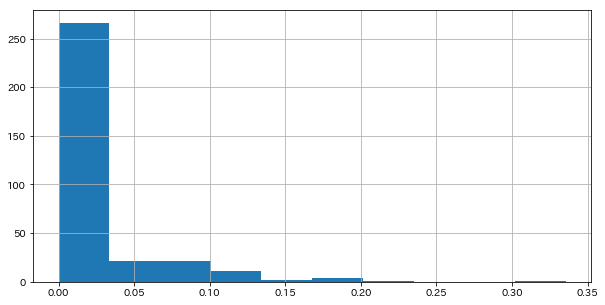

In [30]:
# 標準偏差の値をヒストグラムで描画
std_df['std_tf_idf'].hist(figsize=(10,5))

# グラフより、標準偏差がほぼ0の単語が多い
# 今回は標準偏差が0.010以上の単語のみを特徴量として選択することにする

## 以降、1.品詞で特徴量を絞る場合、2.品詞で特徴量を絞らない場合

## これら2つの特徴量選択を行った時のモデル精度を比較していく

## 1
## 正規表現を使って特定の品詞の単語のみ抽出した場合
下記サイトを使い正規表現のパターンマッチ表現を探索する

https://regex101.com

正規表現一覧は下記

http://gimite.net/help/devas-ja/all_regex.html

In [31]:
# 正規表現によって文字列を抽出する場合はstr.match関数を使用
adjective_df = std_df[std_df['original_type'].str.match('.*_形容詞-.*')]
adjective_df

,original_type,std_tf_idf
226,悪い_形容詞-自立,0.167796
297,良い_形容詞-自立,0.058595
212,嬉しい_形容詞-自立,0.029700
207,多い_形容詞-自立,0.000000
227,悲しい_形容詞-自立,0.000000
223,怖い_形容詞-自立,0.000000
299,若い_形容詞-自立,0.000000
312,軽い_形容詞-自立,0.000000
313,辛い_形容詞-自立,0.000000
320,難しい_形容詞-自立,0.000000


In [32]:
# 形容詞がほとんどないので今回は名詞のみに絞る
# 正規表現によって文字列を抽出する場合はstr.match関数を使用
norm_df = std_df[std_df['original_type'].str.match('.*_名詞-.*')]
norm_df.head()

,original_type,std_tf_idf
154,以上_名詞-非自立-副詞可能,0.335592
263,気_名詞-非自立-一般,0.175561
47,これ_名詞-代名詞-一般,0.174828
246,時間_名詞-副詞可能,0.107860
25,おかげ_名詞-一般,0.107390


In [33]:
# TFIDFの標準偏差0.001以上の単語を抽出
norm0001_df = norm_df[norm_df['std_tf_idf'] >= 0.001]
norm0001_df.head()#18単語しかない、、

,original_type,std_tf_idf
154,以上_名詞-非自立-副詞可能,0.335592
263,気_名詞-非自立-一般,0.175561
47,これ_名詞-代名詞-一般,0.174828
246,時間_名詞-副詞可能,0.107860
25,おかげ_名詞-一般,0.107390


In [34]:
# 抽出した単語部分のカラム１つのみ指定してSeries型にした上でそれをリスト型にする
feature_list = norm0001_df['original_type'].tolist()
feature_list

['以上_名詞-非自立-副詞可能',
 '気_名詞-非自立-一般',
 'これ_名詞-代名詞-一般',
 '時間_名詞-副詞可能',
 'おかげ_名詞-一般',
 '何_名詞-代名詞-一般',
 '案件_名詞-一般',
 'こと_名詞-非自立-一般',
 '皆様_名詞-一般',
 '確認_名詞-サ変接続',
 'そう_名詞-接尾-助動詞語幹',
 'よう_名詞-非自立-助動詞語幹',
 'さ_名詞-接尾-特殊',
 'みんな_名詞-代名詞-一般',
 '勉強_名詞-サ変接続',
 'の_名詞-非自立-一般',
 '事_名詞-非自立-一般',
 '業務_名詞-一般']

## 内容_id×絞った単語のデータフレーム作成

In [35]:
# 品詞とtfidfの標準偏差で絞った単語が格納されたリストを全文書×全単語データフレーム(model_tfidf_df)のカラムに指定するとカラムがリストに格納されていた単語に変換される
norm_std001_model_tfidf_df = model_tfidf_df[feature_list]
norm_std001_model_tfidf_df.head()# 完成

original_type,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,こと_名詞-非自立-一般,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般
内容_id,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.346674,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.351573,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.254045,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.705146,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [37]:
# データフレームをpklファイルとして保存
norm_std001_model_tfidf_df.to_pickle('norm_std001_model_tfidf_df.pkl')

## 2
## 品詞による絞り込みをしない場合

In [38]:
std0001_df = std_df[std_df['std_tf_idf'] >= 0.001]
std0001_df.head()# 77単語

,original_type,std_tf_idf
154,以上_名詞-非自立-副詞可能,0.335592
81,と_助詞-格助詞-引用,0.209340
142,・_記号-一般,0.199143
263,気_名詞-非自立-一般,0.175561
47,これ_名詞-代名詞-一般,0.174828


In [39]:
# 抽出した単語部分のカラム１つのみ指定してSeries型にした上でそれをリスト型にする
feature_list2 = std0001_df['original_type'].tolist()
feature_list2[:19]

['以上_名詞-非自立-副詞可能',
 'と_助詞-格助詞-引用',
 '・_記号-一般',
 '気_名詞-非自立-一般',
 'これ_名詞-代名詞-一般',
 '悪い_形容詞-自立',
 'いう_動詞-自立',
 'で_助詞-格助詞-一般',
 'てる_動詞-非自立',
 'ずっと_副詞-一般',
 'に_助詞-副詞化',
 'くる_動詞-非自立',
 'できる_動詞-自立',
 'ます_助動詞',
 'って_助詞-格助詞-連語',
 'だ_助動詞',
 '考える_動詞-自立',
 '時間_名詞-副詞可能',
 'おかげ_名詞-一般']

## 内容_id×品詞で絞っていない単語のデータフレーム作成

In [40]:
# 品詞とtfidfの標準偏差で絞った単語が格納されたリストを全文書×全単語データフレーム(model_tfidf_df)のカラムに指定するとカラムがリストに格納されていた単語に変換される
std001_model_tfidf_df = model_tfidf_df[feature_list2]
std001_model_tfidf_df.head()# 完成

original_type,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,で_助詞-格助詞-一般,てる_動詞-非自立,ずっと_副詞-一般,...,ある_助動詞,から_助詞-接続助詞,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞
内容_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.705146,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
std001_model_tfidf_df.shape

(50, 77)

In [42]:
# データフレームをpklファイルとして保存
std001_model_tfidf_df.to_pickle('std001_model_tfidf_df.pkl')